In [1]:
import pandas as  pd
import numpy as np
import warnings 
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import datetime 
from scipy import stats
import pandas_profiling
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
import torch.utils.data as Data
from sklearn.model_selection import train_test_split
import torch

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
dataset = pd.read_csv('date_label.csv')

In [4]:
dataset_purchase = pd.read_csv('date_label.csv', usecols=[2], engine='python')
dataset_redeem = pd.read_csv('date_label.csv', usecols=[3], engine='python')

In [5]:
    def create_data_set(data_set):
        data_x, data_y = [], []
        for i in range(len(data_set)-40 - 30):
            a = data_set[i:(i + 40), 0]
            data_x.append(a)
            data_y.append(list(data_set[i + 40: i + 40 + 30, 0]))
        # print(numpy.array(data_y).shape)
        return np.array(data_x), np.array(data_y), data_set[-40:, 0].reshape(1, 1, 40)

In [6]:
   def access_data(data_frame):
        # load the data set
        data_set = data_frame.values
        data_set = data_set.astype('float32')

        # LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing.
        scaler = MinMaxScaler(feature_range=(0, 1))
        data_set = scaler.fit_transform(data_set)

        # reshape into X=t and Y=t+1
        train_x, train_y, test = create_data_set(data_set)

        # reshape input to be [samples, time steps, features]
        train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
        return train_x, train_y, test, scaler

In [7]:
from sklearn.preprocessing import MinMaxScaler
purchase_train_x, purchase_train_y, purchase_test, purchase_scaler = access_data(dataset_purchase)
redeem_train_x, redeem_train_y, redeem_test,redeem_scaler = access_data(dataset_redeem)

In [8]:
batch_size=16
epochs_purchase=150 
epochs_redeem=230
torch_train_purchase = Data.TensorDataset(torch.Tensor(purchase_train_x), torch.Tensor(purchase_train_y))
purchase_train_loader = Data.DataLoader(
    dataset=torch_train_purchase,  # torch TensorDataset format
    batch_size=16,  # mini batch size
    shuffle=False,  # 要不要打乱数据 (打乱比较好)
    num_workers=2,  # 多线程来读数据
)

torch_train_redeem = Data.TensorDataset(torch.Tensor(redeem_train_x), torch.Tensor(redeem_train_y))
redeem_train_loader = Data.DataLoader(
    dataset=torch_train_redeem,
    batch_size=16,  # mini batch size
    shuffle=False,  # 要不要打乱数据 (打乱比较好)
    num_workers=2,  # 多线程来读数据
)

In [9]:
import torch.nn as nn
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
#         input (batch_size, 1, 1)
        self.rnn1 = nn.LSTM(  # if use nn.RNN(), it hardly learns
            input_size=40,
            hidden_size=64,  # rnn hidden unit
            num_layers=1,  # number of rnn layer
            batch_first=True,  # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )
        self.rnn2 = nn.LSTM(
            input_size=64,
            hidden_size=32, 
            num_layers=1,
            batch_first=True,
            )
        self.linear = nn.Linear(32, 32)
        self.out = nn.Linear(32, 30)

    def forward(self, x):
#         print(x.size())
        r1_out, (h_n1, h_c1) = self.rnn1(x, None)
#         print(r1_out.size())
        r2_out, (h_n2, h_c2) = self.rnn2(r1_out, None)
        linear_out = self.linear(r2_out[:, -1, :])
        out = self.out(linear_out)
        return out
    
model = RNN()
model = model.to(device)
model_r = RNN()
model_r = model_r.to(device)
print(model)
import torch.optim as optim
# 定义优化器
optimizer = optim.Adam(model.parameters())
loss_func = nn.MSELoss()
loss_func = loss_func.to(device)
# torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=False, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)

# optimizer_r = optim.Adam(model_r.parameters())
# loss_func_r = nn.MSELoss()

from sklearn.metrics import mean_squared_error

RNN(
  (rnn1): LSTM(40, 64, batch_first=True)
  (rnn2): LSTM(64, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=30, bias=True)
)


In [10]:
import time
start = time.time()
best_loss_p = float('inf')
for epoch in range(801):
    for step, (batch_x, batch_y) in enumerate(purchase_train_loader):
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        
        output = model(batch_x)
#         print('output:',output.size(),'batch_y:',batch_y.size())
        loss = loss_func(output, batch_y)  # cross entropy loss

        optimizer.zero_grad()  # clear gradients for this training step
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()
        mse = mean_squared_error(batch_y.cpu().numpy().tolist(), output.cpu().detach().numpy())
        if loss.cpu().detach().numpy() < best_loss_p:
            best_loss_p = loss.cpu().detach().numpy()
            torch.save(model.state_dict(), 'stock-lstm-p-model.pt')
            
    if epoch % 50 == 0:
        print('epoch: ', epoch, '| loss: ', loss.cpu().detach().numpy(), '| mse: ', mse)
end = time.time()
print('time', end -start)
print('----------------------')
best_loss_r = float('inf')
for epoch in range(801):
    for step, (batch_x, batch_y) in enumerate(redeem_train_loader):
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        
        output = model(batch_x)
#         print('output:',output.size(),'batch_y:',batch_y.size())
        loss = loss_func(output, batch_y)  # cross entropy loss

        optimizer.zero_grad()  # clear gradients for this training step
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()
        mse = mean_squared_error(batch_y.cpu().numpy().tolist(), output.cpu().detach().numpy())
        if loss.cpu().detach().numpy() < best_loss_r:
            best_loss_r = loss.cpu().detach().numpy()
            torch.save(model.state_dict(), 'stock-lstm-r-model.pt')
            
    if epoch % 50 == 0:
        print('epoch: ', epoch, '| loss: ', loss.cpu().detach().numpy(), '| mse: ', mse)
print('time', time.time() -end)

In [14]:
model.load_state_dict(torch.load('stock-lstm-p-model.pt'))
model_r.load_state_dict(torch.load('stock-lstm-r-model.pt'))

pred_purchase = model(torch.Tensor(purchase_test).cuda()).cpu().detach().numpy()
purchase = purchase_scaler.inverse_transform(pred_purchase)

pred_redeem = model_r(torch.Tensor(redeem_test).cuda()).cpu().detach().numpy()
redeem = redeem_scaler.inverse_transform(pred_redeem)
np.shape(purchase)

(1, 30)

    report_date     purchase       redeem
0      20140901  361323328.0  432715008.0
1      20140902  336719360.0  351328960.0
2      20140903  283612896.0  378845024.0
3      20140904  283391168.0  393843808.0
4      20140905  250856240.0  300499008.0
5      20140906  209395680.0  185028032.0
6      20140907  210976848.0  202393776.0
7      20140908  263848016.0  448511328.0
8      20140909  308820032.0  338554112.0
9      20140910  345277216.0  328676928.0
10     20140911  361439808.0  347784128.0
11     20140912  242025408.0  341307680.0
12     20140913  178045296.0  231010368.0
13     20140914  244101776.0  187419840.0
14     20140915  335565664.0  447279808.0
15     20140916  321984384.0  384667840.0
16     20140917  284503008.0  348553312.0
17     20140918  269428384.0  320405088.0
18     20140919  203531632.0  312520224.0
19     20140920  186996720.0  250173184.0
20     20140921  222681280.0  216766304.0
21     20140922  271929312.0  370317536.0
22     20140923  271729248.0  3187

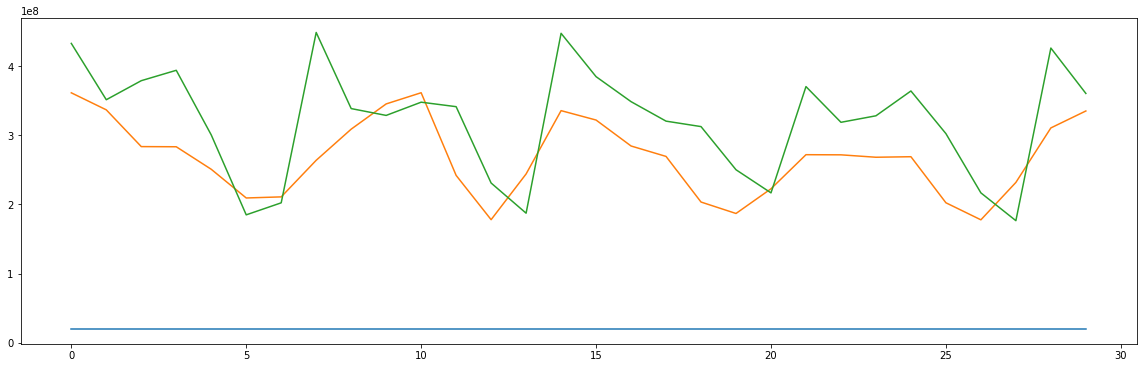

In [15]:
import matplotlib.pyplot as plt
test_user = pd.DataFrame({'report_date': [20140900 + i for i in range(1, 31)]})
np.shape(test_user)
test_user['purchase'] = purchase.reshape(30, 1)
test_user['redeem'] = redeem.reshape(30, 1)
print(test_user)
plt.figure(figsize=(20,6))
plt.plot(test_user)
plt.show()

In [16]:
test_user.to_csv('submit_lstm.csv', encoding='utf-8', index=None, header=None)

In [9]:
def out_func():
    x = 0
    def inner_func():
        x = 1
        print('inner x: ',x)
        print('inner x id: ',id(x))
    print('out x before: ',x)
    print('out x id before: ',id(x))
    inner_func()
    print('out x after: ',x)
    print('out x id after: ',id(x))


In [10]:
a = out_func()

out x before:  0
out x id before:  4369831024
inner x:  1
inner x id:  4369831056
out x after:  0
out x id after:  4369831024
